In [150]:
import warnings
warnings.filterwarnings("ignore")
import pickle
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import stats

In [151]:
def cubic_solution(a2, a1, a0):
    pp1 = (3.0*a1 - a2*a2)/3.0
    qq1 = (9.0*a1*a2 - 27.0*a0 - 2.0*a2*a2*a2)/27.0
    QQQ = pp1/3.0
    RRR = qq1/2.0 
    tht   = np.arccos( RRR / np.sqrt( - QQQ**3.0)  )
    z_one = 2.0 * np.sqrt(-QQQ) * np.cos( tht/3.0  ) - (1.0/3.0)*a2 
    return z_one

In [152]:
def sigma_eff( Pmid ):
        tmp = 12 * ( Pmid * 1e-4 )**0.22
        tmp[tmp < 10.0] = 10.0
        return tmp

In [153]:
def do_hist3d(x, y, w, ax, bin_num, asp, t1,t2, v1, v2, cds):

    y = y[np.isfinite(x)]
    w = w[np.isfinite(x)]
    x = x[np.isfinite(x)]


    x = x[np.isfinite(y)]
    w = w[np.isfinite(y)]
    y = y[np.isfinite(y)]

    x = x[np.isfinite(w)]
    y = y[np.isfinite(w)]
    w = w[np.isfinite(w)]
    

    binsx     = np.linspace(t1,t2,bin_num)
    binsy     = np.linspace(v1,v2,bin_num)
    area      = np.abs(binsx[0]-binsx[1]) * np.abs(binsy[0]-binsy[1]) 
    heatmap1, xedges1, yedges1 = np.histogram2d(x, y, bins=[binsx,binsy], density=False, weights=w)                 
    extent1 = [xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]                                                                                                                                                                

    im1     = ax.imshow(heatmap1.T/w.sum(),extent=extent1,  interpolation='nearest', aspect=asp, origin='lower', 
                        cmap=cds, norm=LogNorm(1e-4,1e-1))      


    return im1

In [154]:
names = ['a', 'b','c', 'd', 'e', 'f']
ids, gas, rho_gas, H_gas, star, rho_star, H_star , rho_dm, sfr = [], [], [], [], [], [], [], [] , []
ns = 0
z  = 0
for name in names:
        sfrrad = np.loadtxt('../new_files/sfrrad_z'+str(z)+'.txt')/(1.+float(z))
        smass  = np.loadtxt('../new_files/gal_props_z'+str(z)+'.dat')[:,2]*1.0e10
        #print("%e %e" %( smass.min(), smass.max())) 
        f1    = open("../new_files/maps_all_z"+str(z)+"_"+name+"_new_gridrad.pkl.gz", "rb")
        grid1 = np.array(pickle.load(f1))
        f1.close()
        
        f2     =  open("../new_files/maps_all_z"+str(z)+"_"+name+"_new_grid.pkl.gz","rb")
        grid2 = np.array(pickle.load(f2))
        f2.close()
        
        
        nn = grid1.shape[0]
        for j in range(nn):
            
            #if  10.0**(11)   > smass[j+ns] > 10.0**(10.0):
            
                rd       = grid1[j].ravel()
                gas1     = grid2[:,1][j].ravel()
                rho_gas1 = grid2[:,2][j].ravel()
                H_gas1   = grid2[:,3][j].ravel() 
                star1    = grid2[:,4][j].ravel()
                rho_star1 =grid2[:,5][j].ravel()
                H_star1  = grid2[:,6][j].ravel()
                rho_dm1  = grid2[:,7][j].ravel()
                sfr1     = grid2[:,8][j].ravel()

                # exclude pixels > r_*_1/2
                gas.append(     gas1[rd < sfrrad[j+ns]] )
                rho_gas.append( rho_gas1[rd < sfrrad[j+ns]] )
                H_gas.append(   H_gas1[rd < sfrrad[j+ns]] )
                star.append(    star1[rd < sfrrad[j+ns]] )
                rho_star.append( rho_star1[rd < sfrrad[j+ns]] )
                H_star.append(    H_star1[rd < sfrrad[j+ns]] )
                rho_dm.append(    rho_dm1[rd < sfrrad[j+ns]] )
                sfr.append(      sfr1[rd < sfrrad[j+ns]] )

        ns+=nn
        
gas, rho_gas, H_gas, star, rho_star, H_star, rho_dm, sfr =  np.concatenate(gas), np.concatenate(rho_gas), np.concatenate(H_gas), np.concatenate(star), np.concatenate(rho_star), np.concatenate(H_star), np.concatenate(rho_dm), np.concatenate(sfr) 

In [155]:
G  = 4.30091e-6 #  kpc M⊙^–1⋅(km/s)2                                                                                                                    
kB = 1.3807e-16 # cm2 g s-2 K-1 

In [156]:
rho_sd  = rho_dm + rho_star
sigma_z = 10.0 #km/s
Acube   = (8.0/3.0) * rho_dm / gas  # kpc^-1
Bcube   = (1.0 +  2.0*star/gas +  Acube*H_star) # unitless
for i in range(20):
        Ccube    = H_star - sigma_z*sigma_z / ( np.pi * G * gas   ) # kpc
        Dcube    = - H_star * sigma_z*sigma_z / ( np.pi * G * gas   ) # kpc^2
        Hg_gsd   = cubic_solution(Bcube/Acube, Ccube/Acube, Dcube/Acube)
        Pmid     =  gas*sigma_z*sigma_z / (2.0 * Hg_gsd) / kB * ( 1.989e+33*(1e5)**2./ (3.086e21)**3.0 ) # K/ cm^3 
        sigma_z  = sigma_eff( Pmid )
        
Upsilon = 10.0**(  -0.212*np.log10( Pmid  )  + 3.86 ) 
sfr_prfm = Pmid/Upsilon * 2.079107930411966e-4 # Msun yr^-1

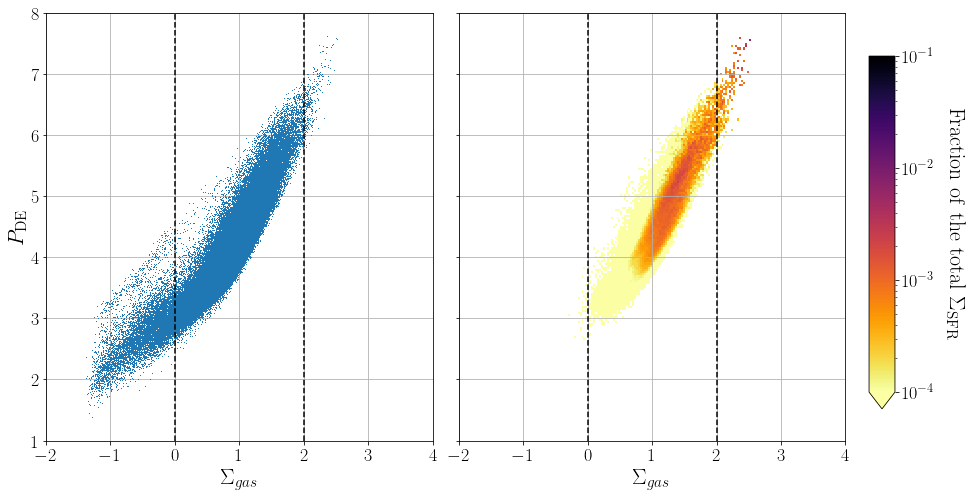

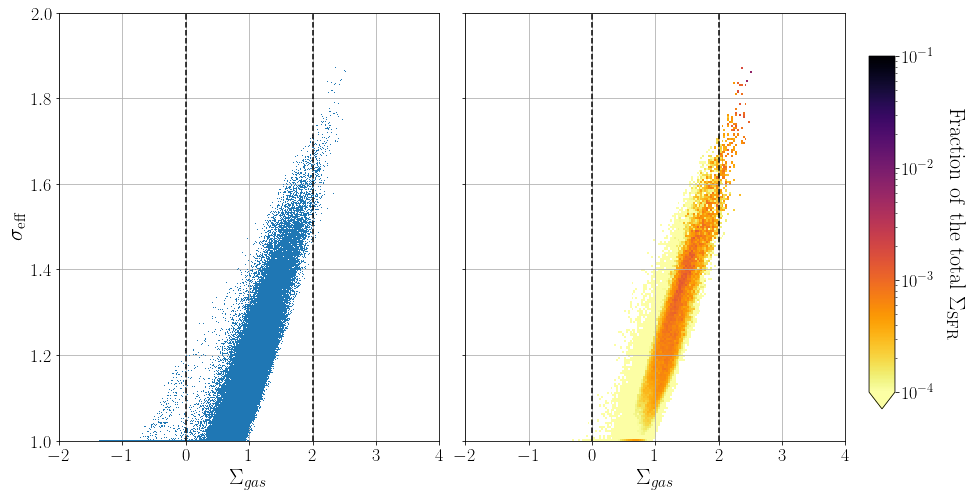

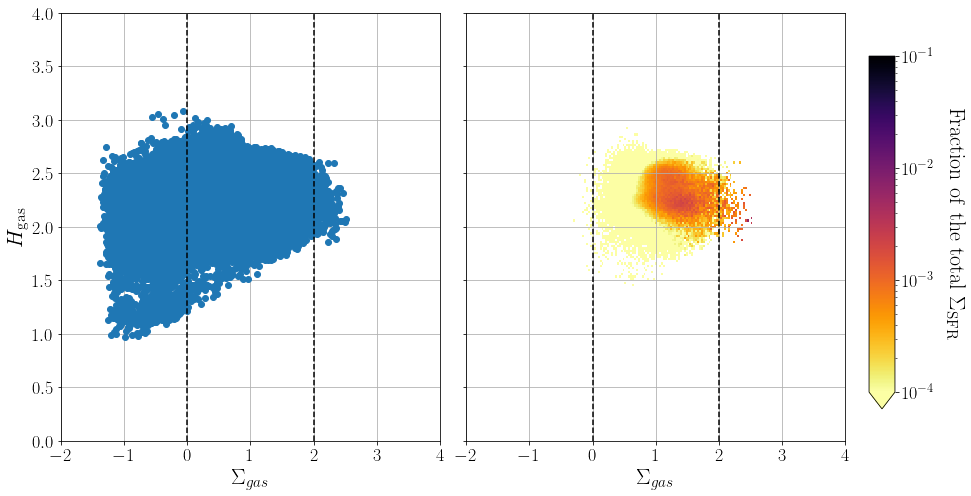

In [157]:
cds ='inferno_r'
nb  = 200 
fig, ax  = plt.subplots(1,2, sharey=True, sharex=True,figsize=(12,7))
ax[0].plot(np.log10(gas)-6.0, np.log10(Pmid),',')
im1 = do_hist3d(np.log10(gas)-6, np.log10(Pmid), sfr.ravel(), ax[1], nb, 'auto', -2,4, 1, 8.,cds)
for i in range(2):
    ax[i].axvline(0, ls='--', color='k')
    ax[i].axvline(2, ls='--', color='k')
    ax[i].grid(True)
    ax[i].set_xlabel(r"$\Sigma_{gas}$", fontsize=22)
    ax[i].tick_params(labelsize=18)

ax[0].set_ylabel(r"$P_{\rm DE}$", fontsize=22)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.18, 0.03, 0.7])
fig.colorbar(im1, cax=cbar_ax, extend='min')
cbar_ax.tick_params(labelsize=18)
cbar_ax.set_ylabel(r"${\rm Fraction\,\, of\,\, the\,\, total\,\,} \Sigma_{\rm SFR}\,$", rotation=270,fontsize=22, labelpad=30)

plt.tight_layout()
plt.show()

fig, ax  = plt.subplots(1,2, sharey=True,sharex=True,figsize=(12,7))
ax[0].plot(np.log10(gas)-6.0, np.log10( sigma_z ),',')
im1 = do_hist3d(np.log10(gas)-6, np.log10( sigma_z ), sfr.ravel(), ax[1], nb, 'auto', -2.,4., 1., 2.,cds)
for i in range(2):
    ax[i].axvline(0, ls='--', color='k')
    ax[i].axvline(2, ls='--', color='k')
    ax[i].grid(True)
    ax[i].set_xlabel(r"$\Sigma_{gas}$", fontsize=22)
    ax[i].tick_params(labelsize=18)

ax[0].set_ylabel(r"$\sigma_{\rm eff}$", fontsize=22)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.18, 0.03, 0.7])
fig.colorbar(im1, cax=cbar_ax, extend='min')
cbar_ax.tick_params(labelsize=18)
cbar_ax.set_ylabel(r"${\rm Fraction\,\, of\,\, the\,\, total\,\,} \Sigma_{\rm SFR}\,$", rotation=270,fontsize=22, labelpad=30)

plt.tight_layout()
plt.show()


fig, ax  = plt.subplots(1,2, sharey=True,sharex=True,figsize=(12,7))
ax[0].plot(np.log10(gas)-6.0, np.log10( Hg_gsd )+3.,'o')
im1 = do_hist3d(np.log10(gas)-6, np.log10( Hg_gsd)+3., sfr.ravel(), ax[1], nb, 'auto', -2.,4., 0., 4.,cds)
for i in range(2):
    ax[i].axvline(0, ls='--', color='k')
    ax[i].axvline(2, ls='--', color='k')
    ax[i].grid(True)
    ax[i].set_xlabel(r"$\Sigma_{gas}$", fontsize=22)
    ax[i].tick_params(labelsize=18)

ax[0].set_ylabel(r"$H_{\rm gas}$", fontsize=22)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.18, 0.03, 0.7])
fig.colorbar(im1, cax=cbar_ax, extend='min')
cbar_ax.tick_params(labelsize=18)
cbar_ax.set_ylabel(r"${\rm Fraction\,\, of\,\, the\,\, total\,\,} \Sigma_{\rm SFR}\,$", rotation=270,fontsize=22, labelpad=30)

plt.tight_layout()
plt.show()